# **1. EDA**
Performing initial investigations on the transformed data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

# **2. Initialization**
Here is where you load all the dependencies required for the good execution of (most of) the notebook. Here is where you load your libraries and instantiate your functions/classes. Here is where you load the data/models/pipelines that are going to be used in the notebook.

## **2.1 Loading libraries**

In [1]:
import numpy as np
import pandas as pd

import time, datetime

## **2.3 Loading data**

In [2]:
df = pd.read_csv('preprocessed_train.csv')
test = pd.read_csv('preprocessed_test.csv')
df['event time:timestamp'] =  pd.to_datetime(df['event time:timestamp'])

#df.drop(columns = ['eventID '], inplace=True) # Drop eventID

## **2.2 Functions**

# **4 Naive estimators **



In [3]:
case_ids=df["case concept:name"].unique()
event_types=df["event concept:name"].unique()

In [4]:
def make_dict(event_types):
    fn={}
    cnt={}
    bk={}
    for j in event_types:
        cnt[j]=0
    for j in event_types:
        fn[j]=cnt
    return fn
info=make_dict(event_types)       
    

In [5]:
case_ids=df["case concept:name"].unique()
def can():  #helper fucntion of naive_est
    fn={} #key position , value most popular event for this position
    dx=df[["index",'position',"event concept:name"]].groupby(["position","event concept:name"]).count().reset_index()
    m=df["position"].unique()
    for pos in m:
        val=dx[dx["position"]==pos]["index"].idxmax()
        pop=dx[dx["position"]==pos]["event concept:name"][val]
        fn[pos]=pop
    return fn


def  naive_est(case_ids):
    db=can()
    def predict(x):
        try:
            return db[x+1]
        except KeyError:
                return db[x]
    
    df["next_event"]= df["position"].apply(predict)
    
    print("Check next_event column in df")
    example_df= df[df["case concept:name"]==case_ids[0]]
    return  example_df[["event concept:name",'next_event']].head(5)
naive_est(case_ids)    

Check next_event column in df


,event concept:name,next_event
0,A_SUBMITTED,A_PARTLYSUBMITTED
1,A_PARTLYSUBMITTED,W_Afhandelen leads
2,A_PREACCEPTED,W_Afhandelen leads
3,W_Completeren aanvraag,W_Completeren aanvraag
4,W_Completeren aanvraag,W_Completeren aanvraag


In [6]:
#After this VIS PART

In [7]:
mp={ j:index+1 for index, j in enumerate(event_types)}

def label_event(x):
    try:
        return mp[x]
    except KeyError:
        return 1
df["label_y"]= df["event concept:name"].apply(label_event)
df["label_ypred"]= df["next_event"].shift(1).apply(label_event)
df["label_ypred"].head()

0     1
1     2
2    21
3    21
4     4
Name: label_ypred, dtype: int64

In [8]:
y_actu = df["label_y"] 
y_pred = df["label_ypred"]

new_df=pd.DataFrame()
new_df["resu"]=y_actu.eq(y_pred)
new_df["pred"]=y_pred

def rev(x):
    if x==False:
        return 0
    if x==True:
        return 1
new_df["pred"]= new_df["resu"].apply(rev)
new_df["resu"]=new_df["resu"].apply(rev)
new_df.head()

,resu,pred
0,1,1
1,1,1
2,0,0
3,0,0
4,1,1


In [9]:
#confusion matrix
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(new_df["resu"],new_df["pred"], labels=[0, 1]).ravel()
print(tn, fp, fn, tp) 

sm= { "TP":[tp,0], "TN":[0,tn]}
dm= pd.DataFrame(sm,index=["TP","TN"])
dm

156860 0 0 82926


,TP,TN
TP,82926,0
TN,0,156860


Text(0.5, 0, 'Accuracy')

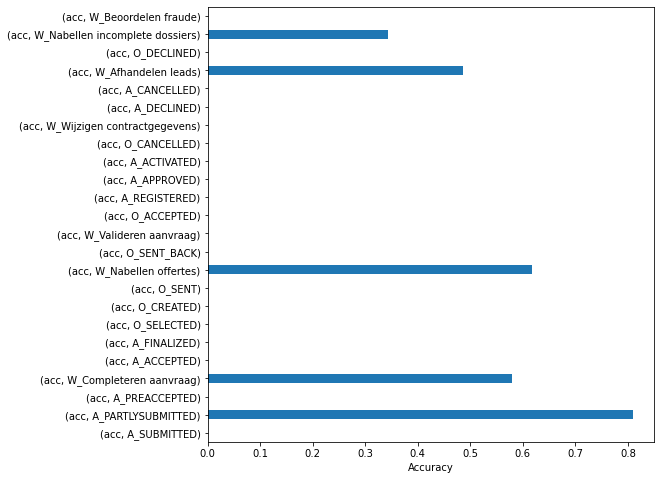

In [10]:
#plot acc per label
acc_label={}
for label in range(1,25):
    curr= df[df["label_y"]==label]
    y= curr["label_y"]
    yhat= curr["label_ypred"]
    p= y.eq(yhat).sum()
    psize= curr["label_y"].size
    acc_label[label]=  p/psize
    
    

pm= {mp[key]:key for key in mp}
fn_vis= {pm[key]: acc_label[key] for key in acc_label }

ax =pd.DataFrame(fn_vis,index=["acc"]).stack().plot(kind="barh",figsize=(8,8))
ax.set_xlabel("Accuracy")  

In [11]:
#other stats baseline model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
    

mse=mean_squared_error(df["label_y"], df["label_ypred"])
f1=f1_score(df["label_y"], df["label_ypred"], average='weighted')
glob_acc= (df["label_y"].eq(df["label_ypred"])).sum() /df["label_y"].size
pre =  precision_score(df["label_y"], df["label_ypred"], average='weighted')
recall=recall_score(df["label_y"], df["label_ypred"], average='weighted')
df_stats= pd.DataFrame( {"MSE":mse, "f1_score":f1, "Accurary":glob_acc,"Precision":pre,"Recall":recall},index=["baseline"])

df_stats

C:\Users\build\anaconda3\envs\labroom\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,MSE,f1_score,Accurary,Precision,Recall
baseline,65.718436,0.266303,0.345833,0.296982,0.345833
